In [29]:
import pandas as pd

# 读取主数据集
df_main = pd.read_csv('merged.csv')

# 读取 GDP 收缩期数据
df_gdp = pd.read_csv('gdp_contraction.csv')

# 将日期列转换为 datetime 格式
df_main['decision_date'] = pd.to_datetime(df_main['decision_date'])
df_gdp['date'] = pd.to_datetime(df_gdp['date'])


创建经济周期区间

In [30]:
# 按日期排序 GDP 数据
df_gdp = df_gdp.sort_values('date')

# 创建区间：将每个 GDP 数据的日期作为区间的起点，下一行的日期作为终点
df_gdp['start_date'] = df_gdp['date']
df_gdp['end_date'] = df_gdp['date'].shift(-1)

# 对于最后一个区间，设置一个未来的日期作为终点
df_gdp['end_date'].iloc[-1] = pd.Timestamp('2100-01-01')


In [31]:
# 创建 IntervalIndex
intervals = pd.IntervalIndex.from_arrays(df_gdp['start_date'], df_gdp['end_date'], closed='left')

# 将 is_contraction 和 gdp_growth_rate 与区间关联
is_contraction_series = pd.Series(df_gdp['is_contraction'].values, index=intervals)
gdp_growth_rate_series = pd.Series(df_gdp['gdp_growth_rate'].values, index=intervals)


In [33]:
# 定义映射函数
def map_is_contraction(date):
    idx = intervals.get_indexer([date])[0]
    return is_contraction_series.iloc[idx]

def map_gdp_growth_rate(date):
    idx = intervals.get_indexer([date])[0]
    return gdp_growth_rate_series.iloc[idx]


# 应用映射函数
df_main['is_contraction'] = df_main['decision_date'].apply(map_is_contraction)
df_main['gdp_growth_rate'] = df_main['decision_date'].apply(map_gdp_growth_rate)

# 检查合并后的 is_contraction 列
print("合并后 is_contraction 的唯一值：", df_main['is_contraction'].unique())
print(df_main.head())

合并后 is_contraction 的唯一值： [False  True]
  decision_date  rate_change   decision sentiment_date  sentiment  \
0    1996-11-13         0.00  No Change     1996-10-30   0.028881   
1    1996-12-17         0.00  No Change     1996-12-04  -0.588398   
2    1997-02-05         0.00  No Change     1997-01-22   0.123663   
3    1997-03-25         0.25   Increase     1997-03-12  -0.728463   
4    1997-05-20         0.00  No Change     1997-05-07  -0.035630   

                                      sentiment_dict  days_difference  \
0  {'positive': 0.1624157875776291, 'negative': 0...               14   
1  {'positive': 0.07799529284238815, 'negative': ...               13   
2  {'positive': 0.17666494846343994, 'negative': ...               14   
3  {'positive': 0.02856595441699028, 'negative': ...               13   
4  {'positive': 0.16252721846103668, 'negative': ...               13   

   is_contraction  gdp_growth_rate  
0           False         1.038370  
1           False         1.03837

In [34]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

在每个经济周期内训练模型

In [35]:
# 定义目标变量
df_main['rate_cut'] = df_main['decision'].apply(lambda x: 1 if x == 'Decrease' else 0)
df_main['rate_change'] = df_main['rate_change'].astype(float)

# 定义特征列表
features = ['sentiment', 'gdp_growth_rate']

# 提取特征和目标变量
X = df_main[features]
y = df_main['rate_cut']

In [36]:
# 确保 is_contraction 列的类型为布尔型
df_main['is_contraction'] = df_main['is_contraction'].astype(bool)

# 获取经济周期列表
cycles = df_main['is_contraction'].unique()
print("经济周期列表：", cycles)

经济周期列表： [False  True]



=== 经济周期：NonRcession ===

--- 模型：Logistic Regression ---
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        21
           1       0.00      0.00      0.00         0

    accuracy                           0.67        21
   macro avg       0.50      0.33      0.40        21
weighted avg       1.00      0.67      0.80        21



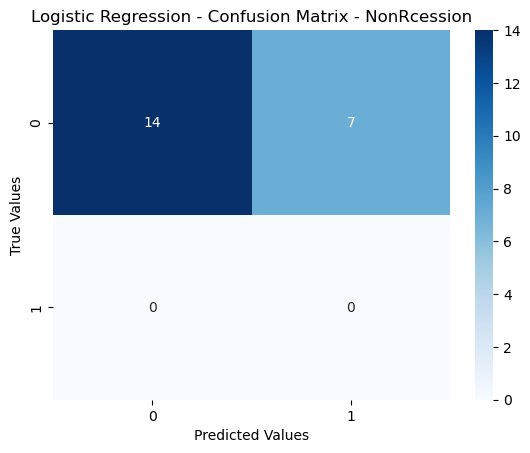


--- 模型：Decision Tree ---
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        21
           1       0.00      0.00      0.00         0

    accuracy                           0.67        21
   macro avg       0.50      0.33      0.40        21
weighted avg       1.00      0.67      0.80        21



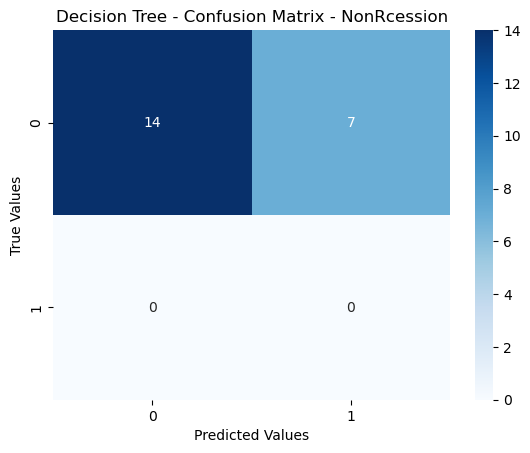


--- 模型：Random Forest ---
              precision    recall  f1-score   support

           0       1.00      0.86      0.92        21
           1       0.00      0.00      0.00         0

    accuracy                           0.86        21
   macro avg       0.50      0.43      0.46        21
weighted avg       1.00      0.86      0.92        21



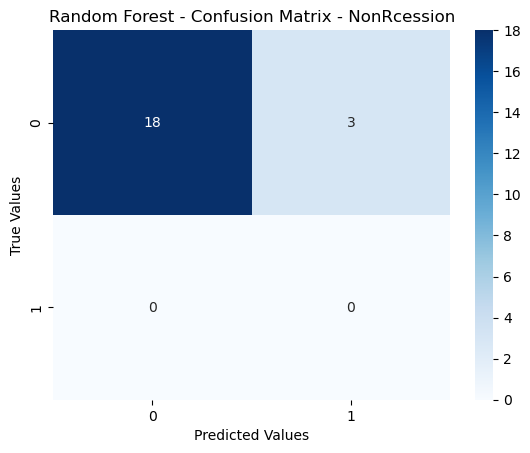


--- 模型：XGBoost ---
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        21
           1       0.00      0.00      0.00         0

    accuracy                           0.67        21
   macro avg       0.50      0.33      0.40        21
weighted avg       1.00      0.67      0.80        21



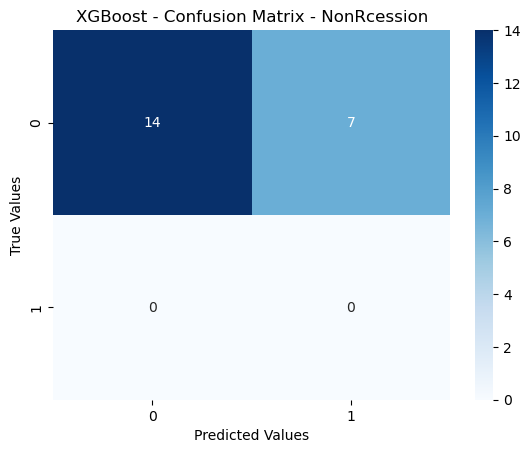


=== 经济周期：Recession ===

--- 模型：Logistic Regression ---
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.00      0.00      0.00         1

    accuracy                           0.86        21
   macro avg       0.47      0.45      0.46        21
weighted avg       0.90      0.86      0.88        21



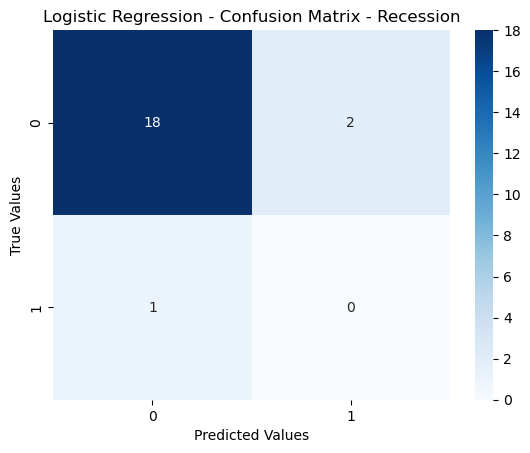


--- 模型：Decision Tree ---
              precision    recall  f1-score   support

           0       1.00      0.65      0.79        20
           1       0.12      1.00      0.22         1

    accuracy                           0.67        21
   macro avg       0.56      0.82      0.51        21
weighted avg       0.96      0.67      0.76        21



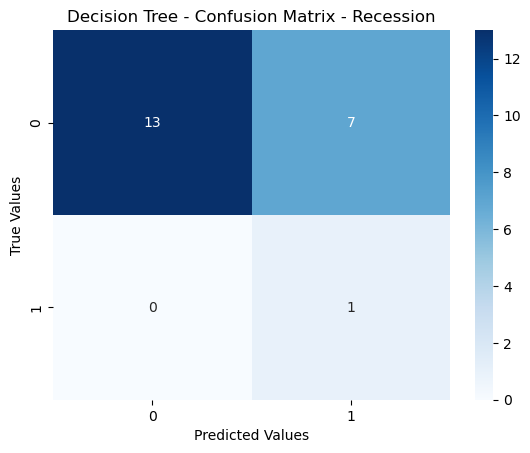


--- 模型：Random Forest ---
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.33      1.00      0.50         1

    accuracy                           0.90        21
   macro avg       0.67      0.95      0.72        21
weighted avg       0.97      0.90      0.93        21



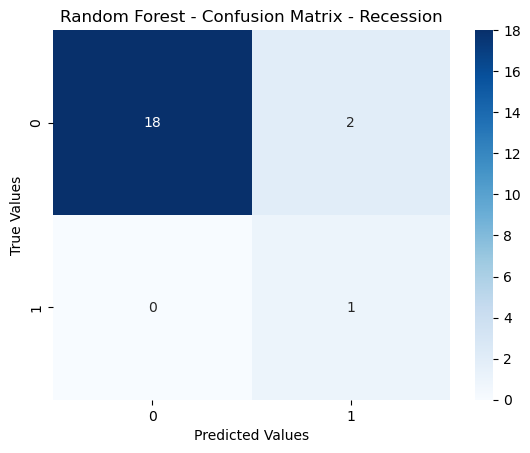


--- 模型：XGBoost ---
              precision    recall  f1-score   support

           0       0.93      0.70      0.80        20
           1       0.00      0.00      0.00         1

    accuracy                           0.67        21
   macro avg       0.47      0.35      0.40        21
weighted avg       0.89      0.67      0.76        21



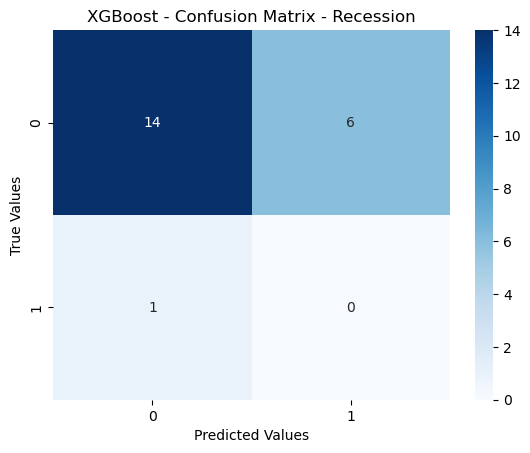

In [43]:
# 初始化结果存储
results = {}

# 遍历每个经济周期
for cycle in cycles:
    cycle_status = 'Recession' if cycle else 'NonRcession'
    print(f"\n=== 经济周期：{cycle_status} ===")
    
    # 筛选当前经济周期的数据
    df_cycle = df_main[df_main['is_contraction'] == cycle]
    
    # 检查数据量是否足够
    if len(df_cycle) < 10:
        print("数据量不足，跳过该周期。")
        continue
    
    X_cycle = df_cycle[features]
    y_cycle = df_cycle['rate_cut']
    
    # 按时间顺序划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X_cycle, y_cycle, test_size=0.2, shuffle=False)
    
    # 处理类别不平衡
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # 定义模型
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    }
    
    results[cycle_status] = {}
    
    # 训练和评估模型
    for model_name, model in models.items():
        print(f"\n--- 模型：{model_name} ---")
        
        # 训练模型
        model.fit(X_train_resampled, y_train_resampled)
        
        # 预测
        y_pred = model.predict(X_test)
        
        # 评估模型
        report = classification_report(y_test, y_pred, output_dict=True)
        print(classification_report(y_test, y_pred))
        
        # 存储结果
        results[cycle_status][model_name] = report
        
        # 绘制混淆矩阵
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{model_name} - Confusion Matrix - {cycle_status}')
        plt.ylabel('True Values')
        plt.xlabel('Predicted Values')
        plt.show()

对RF调参

In [40]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [41]:
# 定义需要调优的超参数
param_grid = {
    'n_estimators': [50, 100, 200],        # 决策树的数量
    'max_depth': [None, 5, 10, 20],        # 树的最大深度
    'min_samples_split': [2, 5, 10],       # 内部节点再划分所需最小样本数
    'min_samples_leaf': [1, 2, 4],         # 叶子节点最小样本数
    'max_features': ['auto', 'sqrt'],      # 每个决策树考虑的最大特征数
    'bootstrap': [True, False]             # 是否有放回地抽样
}


In [42]:
# 定义时间序列拆分
tscv = TimeSeriesSplit(n_splits=5)



=== 参数调优 - 经济周期：NonRcession ===
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


/Users/wooxoo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wooxoo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wooxoo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wooxoo

最佳参数： {'bootstrap': False, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

调优后模型的评估结果：
              precision    recall  f1-score   support

           0       1.00      0.86      0.92        21
           1       0.00      0.00      0.00         0

    accuracy                           0.86        21
   macro avg       0.50      0.43      0.46        21
weighted avg       1.00      0.86      0.92        21



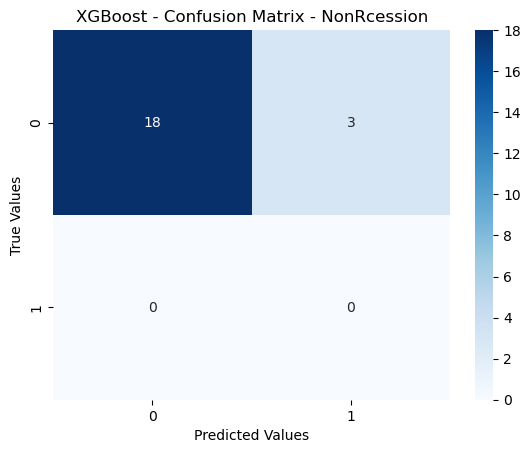


=== 参数调优 - 经济周期：Recession ===
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
最佳参数： {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

调优后模型的评估结果：
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.33      1.00      0.50         1

    accuracy                           0.90        21
   macro avg       0.67      0.95      0.72        21
weighted avg       0.97      0.90      0.93        21



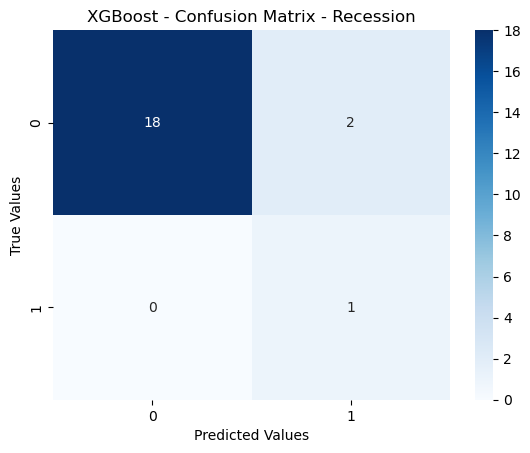

In [44]:
# 初始化结果存储
results = {}

# 遍历每个经济周期
for cycle in cycles:
    cycle_status = 'Recession' if cycle else 'NonRcession'
    print(f"\n=== 参数调优 - 经济周期：{cycle_status} ===")
    
    # 筛选当前经济周期的数据
    df_cycle = df_main[df_main['is_contraction'] == cycle]
    
    # 检查数据量是否足够
    if len(df_cycle) < 10:
        print("数据量不足，跳过该周期。")
        continue
    
    X_cycle = df_cycle[features]
    y_cycle = df_cycle['rate_cut']
    
    # 按时间顺序划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X_cycle, y_cycle, test_size=0.2, shuffle=False)
    
    # 处理类别不平衡
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # 创建随机森林模型
    rf_model = RandomForestClassifier(random_state=42)
    
    # 使用 GridSearchCV 进行参数调优
    grid_search = GridSearchCV(
        estimator=rf_model,
        param_grid=param_grid,
        cv=tscv,
        scoring='f1',    # 使用 F1 分数作为评估指标
        n_jobs=-1,
        verbose=1
    )
    
    # 进行参数调优
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    # 输出最佳参数
    print("最佳参数：", grid_search.best_params_)
    
    # 使用最佳参数训练模型
    best_rf = grid_search.best_estimator_
    best_rf.fit(X_train_resampled, y_train_resampled)
    
    # 在测试集上进行预测
    y_pred = best_rf.predict(X_test)
    
    # 评估模型
    report = classification_report(y_test, y_pred, output_dict=True)
    print("\n调优后模型的评估结果：")
    print(classification_report(y_test, y_pred))
    
    # 将评估结果存储
    results[cycle_status] = {
        'best_params': grid_search.best_params_,
        'classification_report': report
    }
    
    # 绘制混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix - {cycle_status}')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    plt.show()
